## Efficient Supply Allocation for Ride-Hailing Service

### Task Description

The goal of this project is to build a solution that can efficiently guide drivers in a ride-hailing marketplace toward areas with higher expected demand. The task will involve exploring historical ride data to understand patterns in demand across time and space, building a baseline model using historical insights, and then implementing machine learning models to improve the predictions. Finally, recommendations will be provided to drivers in real time based on the model's predictions.

### Chapters and Structures

1. __Introduction__
2. __Preprocessing and Feature Engineering__
2. __Exploratory Data Analysis__
3. __Clustering Analysis__
4. __Baseline Model__
5. __Machine Learning Approach__
6. __Guiding Drivers with Machine Learning Predictions__
7. __Communicating Model Recommendations to Drivers__
8. __Experiment Design for Live Operations__

## Chapter 1: Introduction

- __Problem Statement__:
In a ride-hailing marketplace, efficient supply allocation is essential to ensure that riders get rides quickly and drivers maintain stable earnings. This task focuses on solving this problem by predicting areas of high demand and providing actionable recommendations to drivers.


- __Dataset Overview__:
The dataset includes the following key columns:

    - `start_time`: Timestamp of when the ride request was made
       
    - `start_lat`, `start_lang`: Pickup location coordinates
    
    - `end_lat`, `end_lang`: Droppoff location coordinates
    
    - `ride_value`: Monetary value of the ride

## Chapter 2: Preprocessing and Feature Engineering

In [ ]:
# Import all the required libraries and packages

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import folium

import io
from PIL import Image
import geohash2
from geopy.distance import geodesic

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.model_selection import learning_curve, cross_validate
from sklearn.metrics import mean_absolute_error, r2_score

In [340]:
data = pd.read_csv('robotex5/robotex5.csv', parse_dates=['start_time'])
print(data.shape)
data.head()

(627210, 6)


,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100


In [336]:
# Display basic statistics about the dataset
data.describe()

,start_lat,start_lng,end_lat,end_lng,ride_value
count,627210.000000,627210.000000,627210.000000,627210.000000,627210.000000
mean,59.428682,24.743468,59.397797,24.724847,2.261384
std,0.021764,0.056872,1.392755,1.650709,44.889892
min,59.321557,24.505199,-37.819979,-122.453962,0.107628
25%,59.418803,24.713140,59.415215,24.707919,0.545250
50%,59.432069,24.744674,59.430697,24.744335,1.059000
75%,59.439024,24.768115,59.439262,24.773924,1.712000
max,59.566998,24.973743,61.552744,144.966110,3172.701000


In [337]:
# Check for the null values
data.isna().sum()

start_time    0
start_lat     0
start_lng     0
end_lat       0
end_lng       0
ride_value    0
dtype: int64

In [338]:
# Check for duplicate rows
duplicates = data[data.duplicated()]
duplicates.shape

(4564, 6)

In [341]:
#  Remove duplicate rows to avoid redundancy
data = data.drop_duplicates()
data.shape

(622646, 6)

## Feature Engineering

__Temporal features__

In [343]:
# Extract time-based and date-based features
data['day'] = data['start_time'].dt.day
data['month'] = data['start_time'].dt.month
data['year'] = data['start_time'].dt.year
data['hour'] = data['start_time'].dt.hour
data['minute'] = data['start_time'].dt.minute
data['second'] = data['start_time'].dt.second

data['time_window'] = data['hour'].apply(
    lambda x: 'morning' if 5 <= x < 12 else 'afternoon' if 12 <= x < 17 else 'evening' if 17 <= x < 21 else 'night')

data.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,day,month,year,hour,minute,second,time_window
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825,6,3,2022,15,2,39,afternoon
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750,10,3,2022,11,15,55,morning
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025,6,3,2022,14,23,33,afternoon
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600,3,3,2022,9,11,59,morning
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100,6,3,2022,0,13,1,night


__Spatial features__

In [345]:
# Spatial Features using Geohashing
# Generate geohash codes with precision level 5

data['pickup_geohash'] = data.apply(lambda x: geohash2.encode(x['start_lat'], x['start_lng'], precision=5), axis=1)
data['dropoff_geohash'] = data.apply(lambda x: geohash2.encode(x['end_lat'], x['end_lng'], precision=5), axis=1)


# Distance Feature to calcuate the trip distance using geopy
data['trip_distance_km'] = data.apply(lambda x: geodesic(
    (x['start_lat'], x['start_lng']), (x['end_lat'], x['end_lng'])).kilometers, axis=1)

data.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,day,month,year,hour,minute,second,time_window,pickup_geohash,dropoff_geohash,trip_distance_km
0,2022-03-06 15:02:39.329452,59.407910,24.689836,59.513027,24.831630,3.51825,6,3,2022,15,2,39,afternoon,ud99c,ud9dt,14.205080
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750,10,3,2022,11,15,55,morning,ud9d5,ud9d5,2.050095
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025,6,3,2022,14,23,33,afternoon,ud9d5,ud9d5,0.774715
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600,3,3,2022,9,11,59,morning,ud99c,ud99b,3.041401
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100,6,3,2022,0,13,1,night,ud9d5,ud9dq,9.209442


__Historical Demand Features__

In [360]:
# Calcuate the last 1hr demand for every ride 

new_data = data.copy(deep=False)

# Sort data by start_time
new_data.sort_values('start_time', inplace=True)

# removing the mili seconds for simplicity and for future purpose
new_data['start_time_new'] = new_data['start_time'].apply(lambda x: x.replace(microsecond=0))

Add a small offset to duplicate start times to make them unique
new_data['start_time'] = new_data.groupby('pickup_geohash').apply(
    lambda x: x['start_time'] + pd.to_timedelta(x.groupby('start_time').cumcount(), unit='ms')
).reset_index(drop=True)

# Set start_time as the index as it is needed to apply the rolling window function
new_data.set_index('start_time', inplace=True)

Group by 'pickup_geohash' and apply the rolling window
new_data['demand_last_1hr'] = new_data.groupby('pickup_geohash')['ride_value'].rolling('1H').count().reset_index(level=0, drop=True)

In [361]:
# For each geohash, calculate the demand (i.e., number of rides) per hour.

new_data['ride_count'] = 1  # Each ride is counted as one
demand_per_geohash = new_data.groupby(['pickup_geohash', 'hour']).agg({'ride_count': 'sum'}).reset_index()

# Merge back the demand data into the original dataset
new_data = new_data.merge(demand_per_geohash, on=['pickup_geohash', 'hour'], how='left', suffixes=('', '_demand'))

new_data.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,day,month,year,hour,minute,second,time_window,pickup_geohash,dropoff_geohash,trip_distance_km,start_time_new,ride_count,ride_count_demand
0,2022-03-01 00:00:07.936317,59.438142,24.728677,59.553133,24.802705,3.35200,1,3,2022,0,0,7,night,ud9d4,ud9du,13.479290,2022-03-01 00:00:07,1,3444
1,2022-03-01 00:00:17.556188,59.443230,24.753330,59.391667,24.722047,1.49500,1,3,2022,0,0,17,night,ud9d5,ud99f,6.012515,2022-03-01 00:00:17,1,11031
2,2022-03-01 00:00:20.355945,59.431849,24.768252,59.433692,24.728579,0.55275,1,3,2022,0,0,20,night,ud9d5,ud9d4,2.260878,2022-03-01 00:00:20,1,11031
3,2022-03-01 00:00:20.690881,59.439587,24.748874,59.452895,24.871234,1.73725,1,3,2022,0,0,20,night,ud9d5,ud9dj,7.098048,2022-03-01 00:00:20,1,11031
4,2022-03-01 00:00:25.804142,59.367751,24.645455,59.396104,24.800205,2.28675,1,3,2022,0,0,25,night,ud998,ud99u,9.345522,2022-03-01 00:00:25,1,107


### Outlier Analysis and Detection

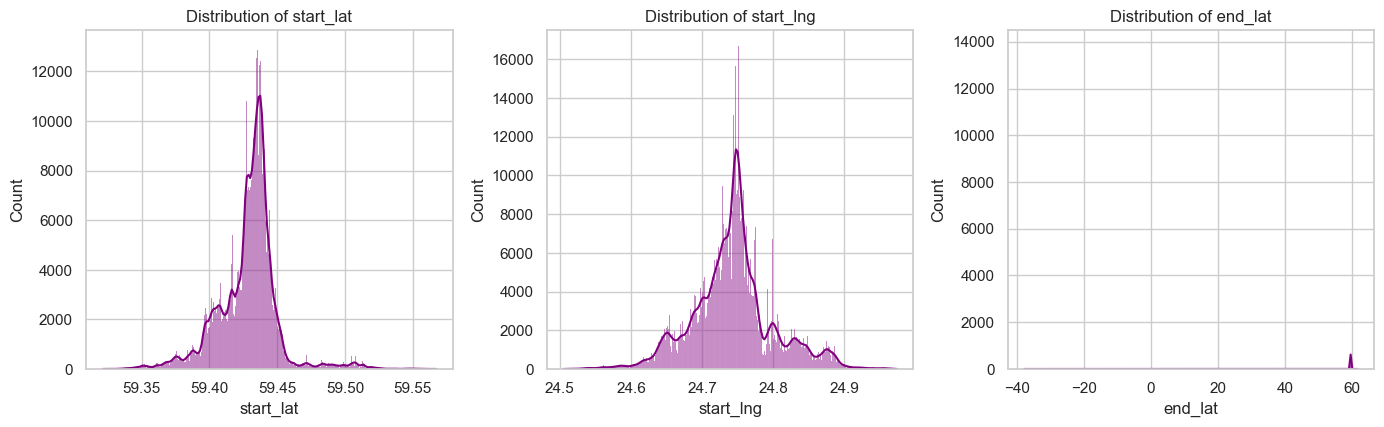

In [370]:
# Set the style for the plots
sns.set(style="whitegrid")

# List of numerical columns to visualize outliers
numerical_columns = ['start_lat', 'start_lng', 'end_lat']

# Distribution Plot (Histogram + KDE) to observe the distribution and outliers
plt.figure(figsize=(14, 8))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(new_data[col], kde=True, color='purple')
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

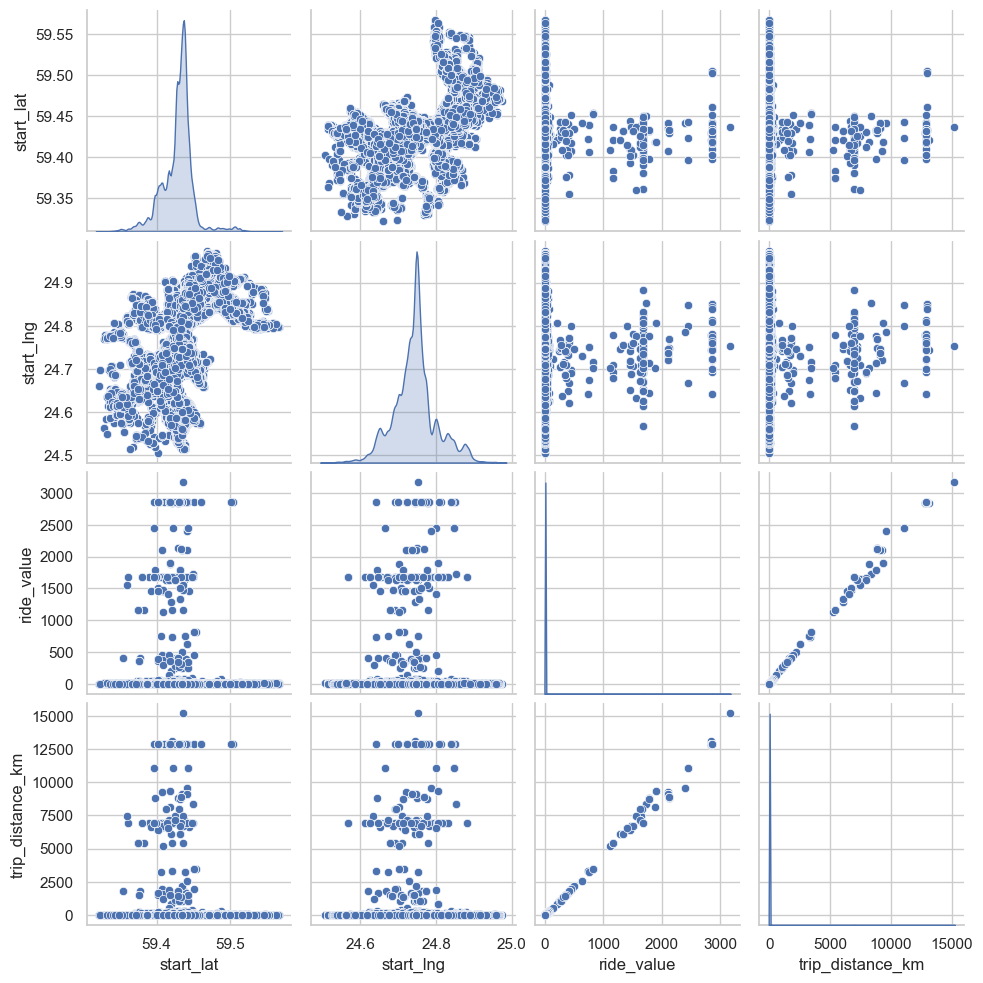

In [375]:
# Pairplot with focus on start_lat, start_lng, ride_value and distance, observing relationships and outliers

numerical_columns = ['start_lat', 'start_lng', 'ride_value', 'trip_distance_km']
sns.pairplot(new_data[numerical_columns], diag_kind='kde', palette="husl")
plt.show()

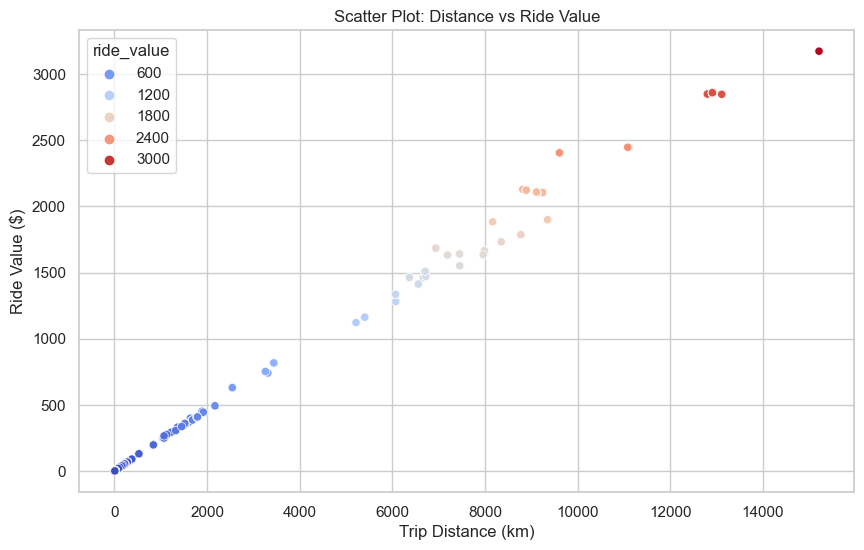

In [366]:
# Scatter plot for detecting outliers based on distance vs ride_value
plt.figure(figsize=(10, 6))
sns.scatterplot(x=new_data['trip_distance_km'], y=new_data['ride_value'], hue=new_data['ride_value'], palette='coolwarm')
plt.title("Scatter Plot: Distance vs Ride Value")
plt.xlabel("Trip Distance (km)")
plt.ylabel("Ride Value ($)")
plt.show()

I am using the __Interquartile Range__ (IQR) method instead of the __Z-score__ method for detecting outliers and can be justified with the following reasons:

- __Robust to Non-Normal Distributions__: The IQR method is more robust when dealing with non-normal (skewed) distributions, as it focuses on the middle 50% of the data. In contrast, the Z-score assumes that the data follows a normal distribution, which may not always be true in real-world datasets like ride-hailing data, where variables such as ride_value or trip_distance_km could be skewed.

- __Less Sensitive to Extreme Values__: The IQR method is less affected by extreme outliers because it relies on the median and quartiles rather than the mean and standard deviation (used by the Z-score). This makes IQR a more suitable choice when dealing with datasets that contain significant outliers, ensuring that the presence of a few extreme values does not distort the overall analysis.

In [369]:
Q1 = data['ride_value'].quantile(0.25)
Q3 = data['ride_value'].quantile(0.75)
IQR = Q3 - Q1

lower_threshold = Q1 - 2*IQR
upper_threshold = Q3 + 2*IQR

print(f'Q1: {Q1}\nQ3: {Q3}\nlower_threshold: {lower_threshold}\nupper_threshold: {upper_threshold}')

prc = 100 * (1 - data[(lower_threshold <= data['ride_value']) & (data['ride_value'] <= upper_threshold)].shape[0] / data.shape[0])
print(f'Percentage of very high values for ride_value: {round(prc, 2)}%')

Q1: 0.54525
Q3: 1.712
lower_threshold: -1.78825
upper_threshold: 4.0455
Percentage of very high values for ride_value: 1.34%


## Chapter 3: Exploratory Data Analysis

1. __Temporal Demand Analysis__

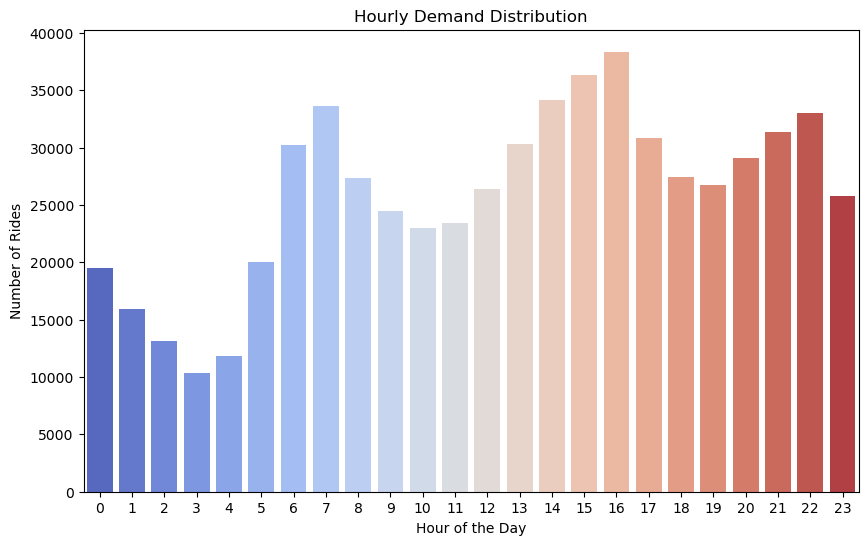

In [50]:
# Group data by hour to see hourly demand
hourly_demand = new_data.groupby('hour').size()

# Plot hourly demand
plt.figure(figsize=(10, 6))
sns.barplot(x=hourly_demand.index, y=hourly_demand.values, palette='coolwarm')
plt.title('Hourly Demand Distribution')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides')
plt.show()

#### Business Insight:

- __Peak Hours:__ The plot shows the hours with high ride demand, typically around rush hours (e.g., morning and evening commutes).
- __Action:__ Drivers should be concentrated in areas with the highest demand during peak hours, ensuring riders don’t face long wait times.

2. __Spatial Demand Analysis with Geohashes__

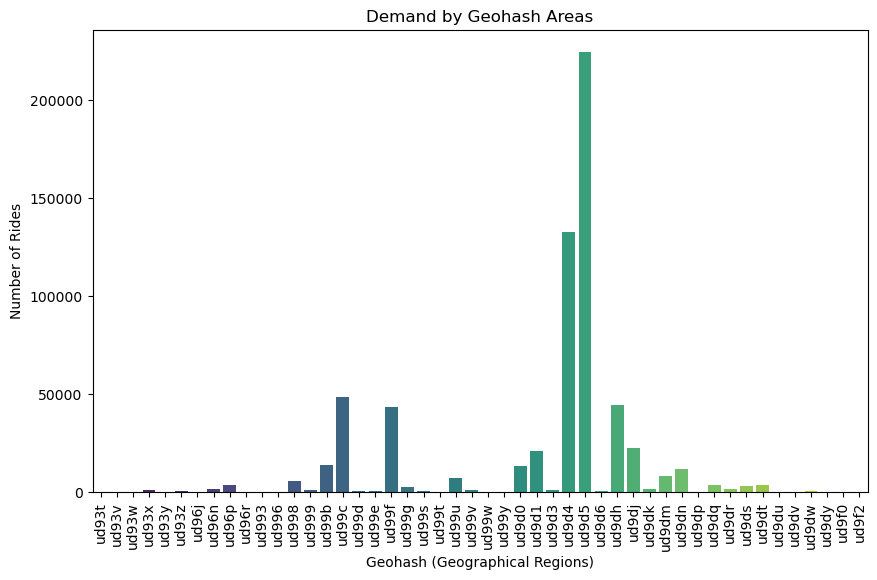

In [53]:
# Group data by geohash to see geohash demand
geohash_demand = new_data.groupby('pickup_geohash').size().reset_index(name='ride_count')

# Plotting geohash demand using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='pickup_geohash', y='ride_count', data=geohash_demand, palette='viridis')
plt.title('Demand by Geohash Areas')
plt.xticks(rotation=90)
plt.xlabel('Geohash (Geographical Regions)')
plt.ylabel('Number of Rides')
plt.show()

#### Business Insight:
- __High-Demand Geohashes__: The plot identifies geographical hotspots where demand is consistently high. Drivers can be directed to these areas during non-peak times to maximize their utilization.
- __Action__: Allocate more drivers to these hotspots to balance supply and demand.

3. __Spatial Heatmaps for Demand Hotspots__

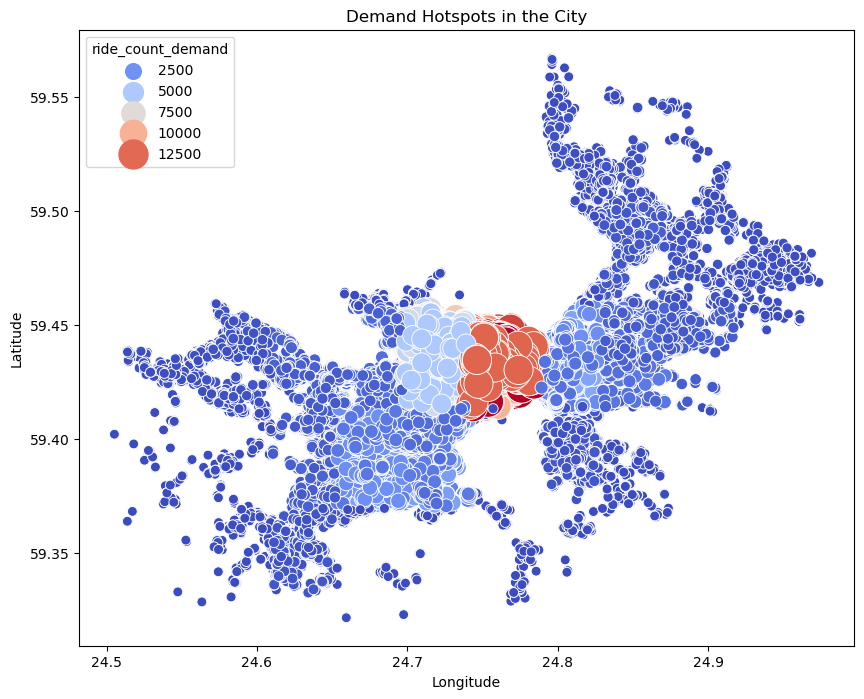

In [54]:
# Visualize geospatial demand using scatter plot

plt.figure(figsize=(10, 8))
sns.scatterplot(x='start_lng', y='start_lat', size='ride_count_demand', hue='ride_count_demand', data=new_data, palette='coolwarm', sizes=(50, 500))
plt.title('Demand Hotspots in the City')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### Business Insight:
- __Demand Hotspots__: The scatter plot provides a clear picture of where demand is concentrated, helping drivers to focus on areas with high ride demand.
- __Action__: Implement dynamic pricing or surge pricing in these areas to optimize earnings for drivers and ensure quick ride allocation.

4. __Heatmaps for Temporal Demand by Geohash__

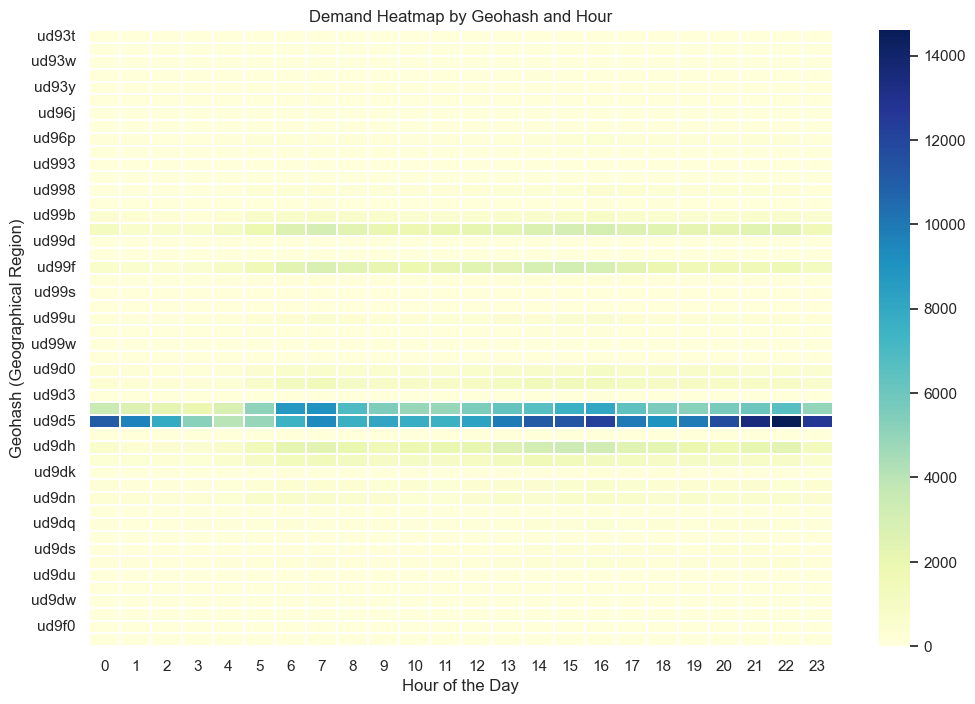

In [376]:
# Create a pivot table for demand heatmap (geohash x hour)
demand_pivot = new_data.pivot_table(values='ride_count', index='pickup_geohash', columns='hour', aggfunc='sum', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(demand_pivot, cmap='YlGnBu', linewidths=0.1)
plt.title('Demand Heatmap by Geohash and Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Geohash (Geographical Region)')
plt.show()

#### Business Insight:
- __Time and Space Demand Correlation__: This heatmap provides an in-depth look at when specific areas (geohashes) experience the highest demand.
- __Action__: Drivers can be directed to different areas depending on the time of day, ensuring they are always in high-demand zones.

5. __Demand Over Time in Different Geohash Areas__

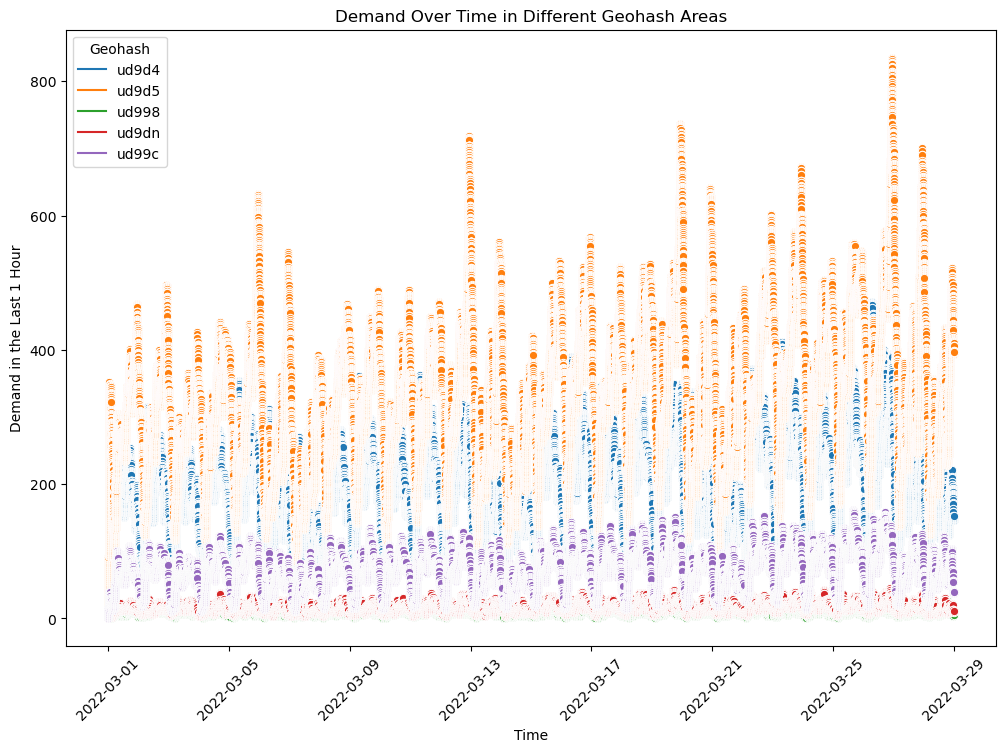

In [62]:
# Sample a few geohashes to make the plot readable
sample_geohashes = new_data['pickup_geohash'].unique()[:5]  # Taking first 5 geohashes as an example
sample_data = new_data[new_data['pickup_geohash'].isin(sample_geohashes)]

# Plot demand_last_1hr over time for selected geohashes
plt.figure(figsize=(12, 8))
sns.lineplot(data=sample_data, x='start_time_new', y='demand_last_1hr', hue='pickup_geohash', marker='o')
plt.title('Demand Over Time in Different Geohash Areas')
plt.xlabel('Time')
plt.ylabel('Demand in the Last 1 Hour')
plt.legend(title='Geohash')
plt.xticks(rotation=45)
plt.show()

#### Business Insight:
- __Consistent High-Demand Geohashes__: Some geohash areas may show consistently high demand across different times, making them prime locations for driver allocation. Drivers in these regions can expect stable earnings throughout the day.
- __Action__: Direct more drivers to these consistently high-demand geohashes during peak hours, while also dynamically adjusting allocations based on hourly trends.

6. __Comparing Ride Value with Recent Demand__

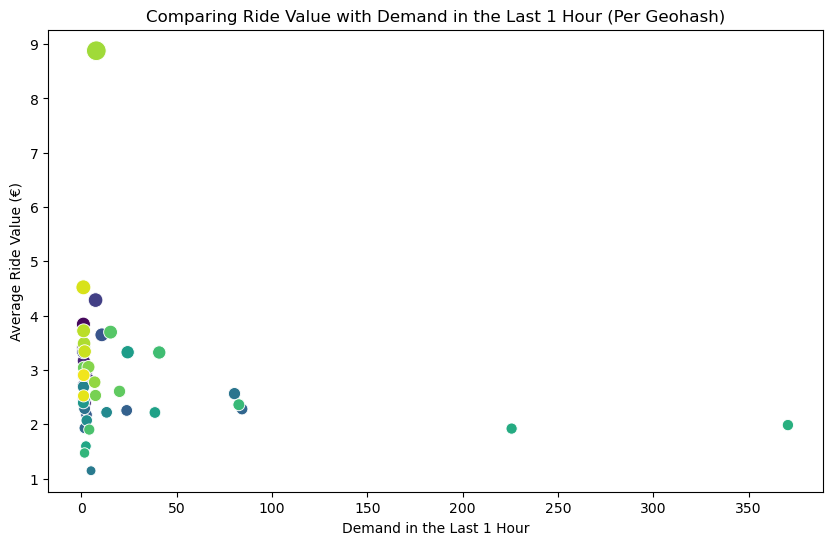

In [64]:
# Group data by geohash to get average ride value and demand_last_1hr
geohash_summary = new_data.groupby('pickup_geohash').agg({
    'demand_last_1hr': 'mean',  # Mean demand in the last 1 hour
    'ride_value': 'mean'  # Mean ride value
}).reset_index()

# Scatter plot to compare demand_last_1hr and ride_value
plt.figure(figsize=(10, 6))
sns.scatterplot(data=geohash_summary, x='demand_last_1hr', y='ride_value', hue='pickup_geohash', size='ride_value', sizes=(50, 200), palette='viridis', legend=False)
plt.title('Comparing Ride Value with Demand in the Last 1 Hour (Per Geohash)')
plt.xlabel('Demand in the Last 1 Hour')
plt.ylabel('Average Ride Value (€)')
plt.show()

#### Business Insight:
- __Correlation Between Demand and Ride Value__: This plot reveals whether higher demand correlates with higher ride values. If geohashes with higher demand also show higher ride values, drivers should prioritize these areas to maximize earnings. On the other hand, if high-demand areas have lower ride values, it may be beneficial for drivers to balance between demand and value.

## Chapter 4: Clustering

Based on the explortory data analysis, it can be understood that the majority of the data is densely located in the central region. Therefore, the clustering algorithm should be chosen carefully for better results. Below are the reasons:

- __Density-based algorithms (like DBSCAN)__: These algorithms are designed to identify dense regions as clusters and often struggle with large, densely packed areas. DBSCAN, for example, might treat the entire dense central area as a single large cluster, making it difficult to split this into meaningful sub-clusters.


- __Distribution-based algorithms (like Gaussian Mixture Models - GMM)__: These algorithms assume that the data comes from a distribution (often Gaussian). In dense areas, GMM might also model the entire central region as a single distribution, failing to separate meaningful sub-regions unless there's a clear separation in the data.


Given the need to split a dense central area into smaller, more granular regions:

- __K-Means Clustering__ is a good choice in this case. It splits the data into a predefined number of clusters based on distance to centroids, making it effective at dividing even dense areas into smaller subregions. 
    - __Why K-Means?__ It doesn't rely on density, but instead minimizes the distance within clusters, which allows it to divide dense regions into multiple smaller clusters.

__K-Means Clustering__:

- __Disclaimer__: Due to computational limitations with a 4-core system, performing K-means clustering on over 600,000 data points is very time-consuming. As a result, I opted to cluster data from only the first 4 days of the month, as it effectively represents the entire dataset.

In [176]:
warnings.filterwarnings("ignore")

# Extracting the required features: start_lat and start_lng for clustering
new_data_0 = new_data[(new_data['day'].isin([1,2,3,4]))]
X = new_data_0[['start_lat', 'start_lng']]

# List to store silhouette scores for each k
silhouette_scores = []

# Test different values of k (number of clusters)
k_values = range(7, 20)  # You can change the range based on your dataset size

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    
    # Predict the cluster for each data point
    labels = kmeans.labels_
    
    # Calculate silhouette score
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    print(f'Done with {k}')

Done with 7
Done with 8
Done with 9
Done with 10
Done with 11
Done with 12
Done with 13
Done with 14
Done with 15
Done with 16
Done with 17
Done with 18
Done with 19


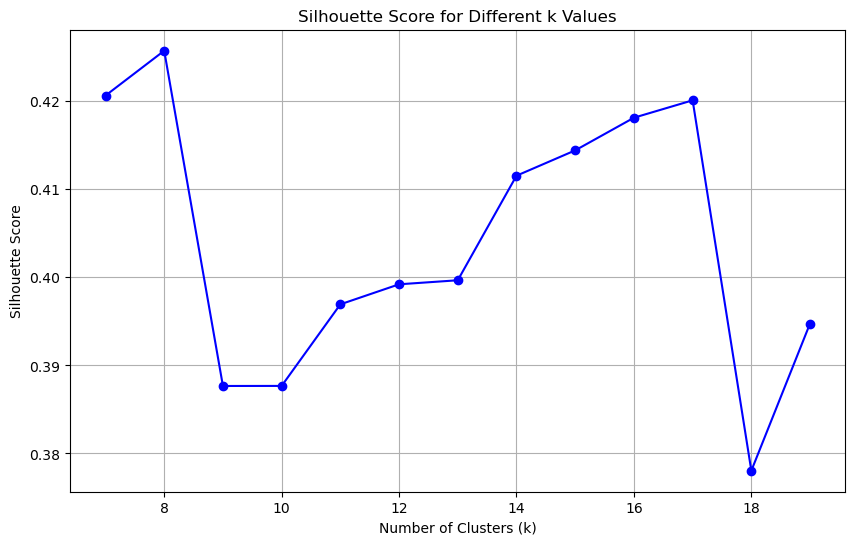

In [177]:
# Plot the silhouette score for each value of k

plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score for Different k Values')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

__Silhouette Score Plot__: This will show the performance of the K-Means algorithm for different values of `k`. The optimal number of clusters is where the Silhouette Score is highest. It can be observed that the `k` value of `8` gives the highest Silhoutte Score.

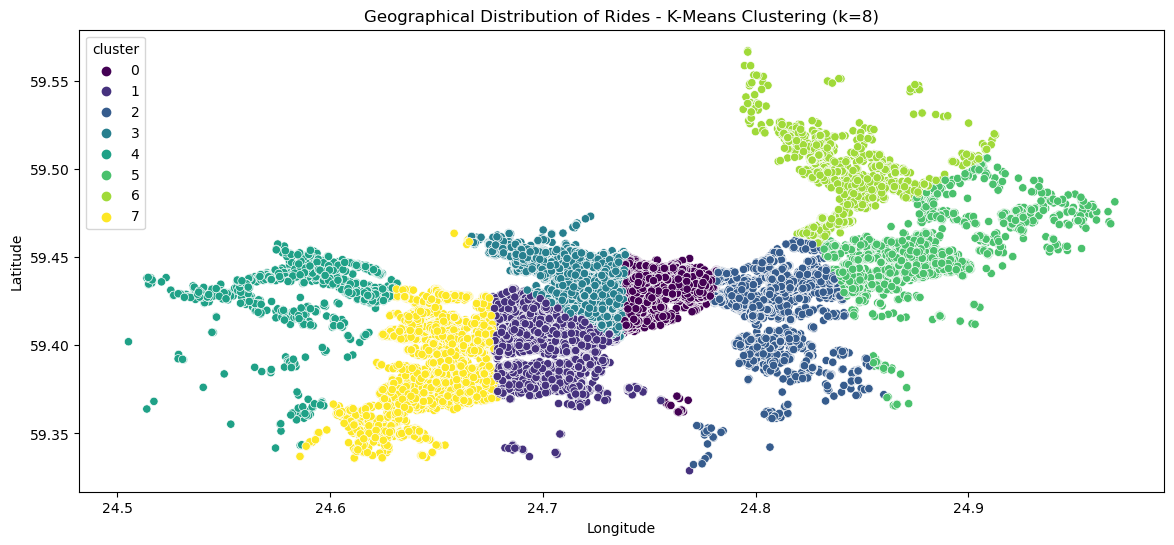

In [180]:
# Find the best k (with the highest silhouette score)
best_k = k_values[silhouette_scores.index(max(silhouette_scores))]

# Fit the KMeans model again with the best k
kmeans_best = KMeans(n_clusters=best_k, random_state=42)
new_data_0['cluster'] = kmeans_best.fit_predict(X)

# Plot the distribution of the best clusterer
plt.figure(figsize=(14, 6))
sns.scatterplot(x='start_lng', y='start_lat', hue='cluster', palette='viridis', data=new_data_1, legend='full')
plt.title(f'Geographical Distribution of Rides - K-Means Clustering (k={best_k})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

__Cluster Distribution Plot__: The best clustering model (with the optimal `k`) is visualized on the map, showing how the K-Means algorithm divides the central dense region into meaningful sub-regions.

## Cluster Analysis

Once we have the optimal number of clusters from the K-Means model, we can analyze each cluster in terms of:

- __Geographical Spread__: Where the clusters are located.
- __Ride Demand__: The number of rides and demand density in each cluster.
- __Average Ride Value__: The average ride value in each cluster, indicating profitability for drivers.
- __Distance__: Whether certain clusters tend to have longer or shorter trips.

1. __Cluster-wise Analysis__

In [386]:
cluster_stats = new_data_0.groupby('cluster').agg({
    'ride_value': ['mean', 'count'],  # Average ride value and number of rides
    'trip_distance_km': 'mean', # Average trip distance
    'demand_last_1hr': 'mean'     
}).reset_index()

# Rename columns for clarity
cluster_stats.columns = ['cluster', 'avg_ride_value', 'ride_count', 'avg_trip_distance', 'avg_demand_last_1hr']

cluster_stats

,cluster,avg_ride_value,ride_count,avg_trip_distance,avg_demand_last_1hr
0,0,1.757371,29771,7.301054,303.224682
1,1,2.383156,9856,10.048491,80.220475
2,2,2.910874,8055,12.339489,86.062694
3,3,1.754679,16253,7.335528,178.283763
4,4,3.832632,1161,15.686522,10.161068
5,5,3.465880,4487,14.705846,24.915757
6,6,5.174016,2131,22.179772,9.463632
7,7,2.498753,7443,10.190772,41.125621


__Insight 1: Profitability of Different Clusters__:

- The `avg_ride_value` column helps determine which clusters are more profitable based on the average ride value.
- __Action__: If certain clusters have a high ride value but moderate demand, these areas could be targeted by drivers looking to maximize their per-ride earnings. Conversely, clusters with low ride values may not be worth prioritizing unless the demand is extremely high.


__Insight 2: Trip Distance Patterns__:

- The `avg_trip_distance` column indicates whether rides in certain clusters tend to be longer or shorter. Clusters with longer trips may require fewer drivers to maintain efficiency.
- __Action__: Allocate drivers based on trip lengths, ensuring areas with frequent shorter trips are better covered by a higher number of drivers.

2. __Cluster Visualization__:
Visualization of the distribution of key metrics (such as ride value and demand) across different clusters.

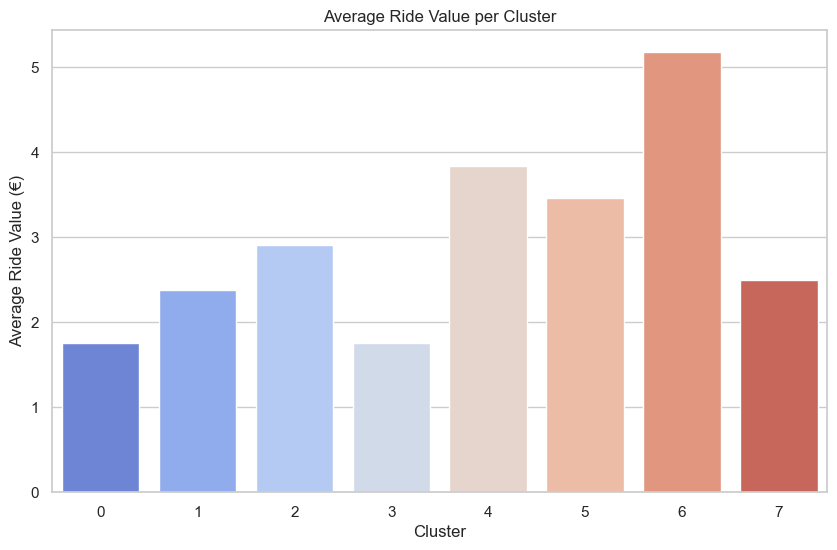

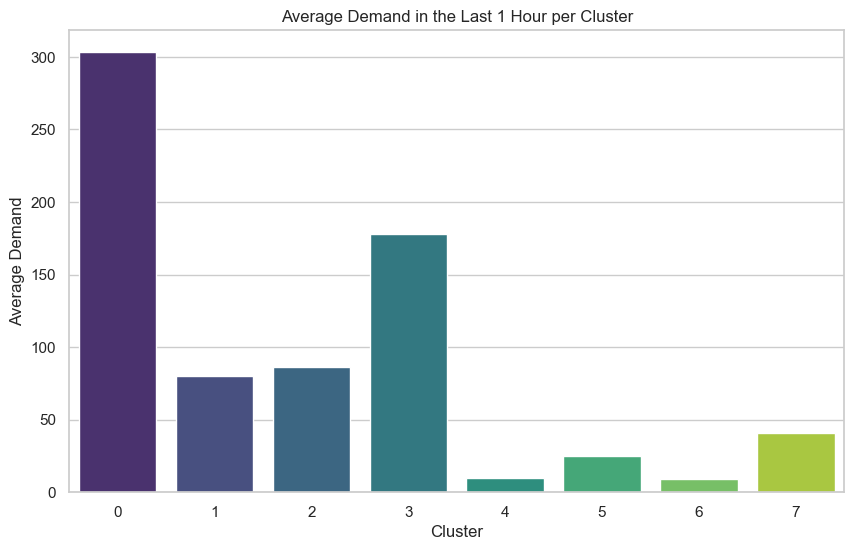

In [387]:
# Plotting the average ride value for each cluster
plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='avg_ride_value', data=cluster_stats, palette='coolwarm')
plt.title('Average Ride Value per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Ride Value (€)')
plt.show()

# Plotting the average demand in the last 1 hour for each cluster
plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='avg_demand_last_1hr', data=cluster_stats, palette='viridis')
plt.title('Average Demand in the Last 1 Hour per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Demand')
plt.show()

__Business Insight__:

While cluster `0` receives the most rides overall, cluster `6` boasts the highest average ride value. Although cluster `6` experiences fewer rides, its high average fare suggests that drivers could potentially earn more per ride in this cluster.

## Chapter 5: Baseline Model

__Approach__:

- __Locate the driver__: Given the driver’s current latitude and longitude, we first determine which cluster the driver belongs to (using the K-Means model we’ve already trained).
- __Select nearby regions__: We focus only on the regions (geohashes) within the driver’s cluster.
- __Historical data__: For the driver's current time window (e.g., morning, afternoon, night), we use the historical demand and ride profitability within that cluster to recommend the best nearby geohash.
- __Profit-based Recommendation__: We rank the geohashes within the cluster not only by demand but also by average ride value to help drivers maximize their earnings.

__Implementation__:

1. __Determine Driver’s Cluster__:
Using the `K-Means model` we already trained, we can predict which cluster the driver belongs to based on their current latitude and longitude.

In [182]:
# We have the K-Means model already fitted
driver_location = {'lat': 59.437, 'lng': 24.753}  # Example driver location (latitude, longitude)

# Predict the cluster for the driver's location
driver_cluster = kmeans_best.predict([[driver_location['lat'], driver_location['lng']]])[0]
print(f"Driver belongs to cluster: {driver_cluster}")

Driver belongs to cluster: 0


2. __Focus on Nearby Regions (within the Driver's Cluster)__:
Filter the historical data to consider only the geohashes (regions) within the driver's cluster.

In [389]:
# Filter the historical demand data to only include the driver's cluster
cluster_demand_data = new_data_0[new_data_0['cluster'] == driver_cluster]

# Further filter the data by the current time window (e.g., morning, afternoon, night)
current_time_window = 'night'
current_hour = 17
current_dow = 4

cluster_demand_time_window = cluster_demand_data[cluster_demand_data['time_window'] == current_time_window]

3. __Rank Regions by Historical Profitability and Demand__:
Rank the geohashes within the driver's cluster based on historical demand and profitability (ride value).

In [391]:
# Group by pickup_geohash and aggregate historical demand and average ride value
cluster_demand_summary = cluster_demand_time_window.groupby('pickup_geohash').agg({
    'ride_count': 'sum',  # Total historical demand
    'ride_value': 'mean'  # Average ride value (profitability)
}).reset_index()

# Sort by ride_value (profitability) and ride_count (demand) to rank the regions
cluster_demand_summary['profit_rank'] = cluster_demand_summary['ride_value'].rank(ascending=False)
cluster_demand_summary['demand_rank'] = cluster_demand_summary['ride_count'].rank(ascending=False)
cluster_demand_summary['final_rank'] = (cluster_demand_summary['profit_rank'] + cluster_demand_summary['demand_rank']) / 2

# Sort the geohashes by final rank (combining demand and profit)
cluster_demand_summary = cluster_demand_summary.sort_values('final_rank')

# Select the top geohash as the recommendation
recommended_geohash = cluster_demand_summary.iloc[0]['pickup_geohash']
print(f"Recommended geohash for the driver in cluster {driver_cluster} during {current_time_window}: {recommended_geohash}")

Recommended geohash for the driver in cluster 0 during night: ud9d5


In [392]:
# To have an idea of how the cluster demand summary looks:

print(cluster_demand_summary)

  pickup_geohash  ride_count  ride_value  profit_rank  demand_rank  final_rank
4          ud9d5        9144    2.116695          1.0          1.0         1.0
1          ud99f          54    1.276963          3.0          3.0         3.0
0          ud99e           3    2.077167          2.0          5.0         3.5
3          ud9d4         307    0.972717          5.0          2.0         3.5
2          ud99g          52    1.034096          4.0          4.0         4.0


In [200]:
# Filter the data to only include rides in the driver's cluster and the current hour
cluster_demand_time = new_data_0[(new_data_0['cluster'] == driver_cluster) & 
                                      (new_data_0['hour'] == current_hour)]

# Calculate the total number of rides requested and the average revenue (ride_value)
rides_requested = cluster_demand_time_window['ride_count'].sum()
average_revenue = cluster_demand_time_window['ride_value'].mean()

# Display the final output 
print(f"The driver's current cluster is {driver_cluster}. At {current_hour}:00, "
      f"there were {int(rides_requested)} rides requested in this cluster with an average revenue of ${average_revenue:.2f}.")

The driver's current cluster is 0. At 17:00, there were 9560 rides requested in this cluster with an average revenue of $2.07.


__Observations and Insights__:
- Based on the driver's current cluster and the time of day, this enhanced baseline model suggests the best region nearby, considering both historical demand and profitability.
- By focusing on local clusters, we ensure that drivers are directed to nearby profitable areas rather than distant regions that could result in wasted time or fuel.

## Chapter 6: Machine Learning Approach

A better approach is to consider the historic data and build a predictive model that could predict the demand in real-time

__Feature Selection__:

Not all the features that are derived before are important for training ML models. Therefore, most of them are being discarded keeping only the relevant ones.

`Cluster` and `pickup_geohash` are label encoded to convert the spatial regions into numerical labels.

In [393]:
new_data_1 = new_data_0[['cluster','hour','ride_value','pickup_geohash']]
new_data_1['dow'] = new_data_0['start_time_new'].dt.day_of_week


label_encoder = LabelEncoder()

new_data_1['cluster'] = label_encoder.fit_transform(new_data_1['cluster'])
new_data_1['pickup_geohash'] = label_encoder.fit_transform(new_data_1['pickup_geohash'])
new_data_1

,cluster,hour,ride_value,pickup_geohash,dow
0,3,0,3.35200,25,1
1,0,0,1.49500,26,1
2,0,0,0.55275,26,1
3,0,0,1.73725,26,1
4,7,0,2.28675,9,1
...,...,...,...,...,...
79152,3,23,1.16700,25,4
79153,5,23,1.59400,29,4
79154,0,23,0.95025,26,4
79155,0,23,1.38850,26,4


In [394]:
# Final dataset for further training and tuning

final_data = new_data_1.groupby(['cluster', 'dow', 'hour', 'pickup_geohash']).count().reset_index().rename(
    columns={'ride_value': 'ride_count'})

final_data

,cluster,dow,hour,pickup_geohash,ride_count
0,0,1,0,16,3
1,0,1,0,25,9
2,0,1,0,26,334
3,0,1,1,15,1
4,0,1,1,16,1
...,...,...,...,...,...
3558,7,4,23,10,1
3559,7,4,23,11,18
3560,7,4,23,12,26
3561,7,4,23,22,11


### Spearman Correlation Matrix:

Spearman correlation matrix is crucial when:

- __Data is non-linearly related__: Spearman correlation can detect monotonic relationships, even if the data points don't follow a straight line.
- __Data is ordinal or ranked__: When dealing with data that is ranked or categorized, Spearman correlation provides a suitable measure of association.
- __Detect multicollinearity__: If two or more independent variables have a high Spearman correlation, it suggests that they may be highly correlated and could cause multicollinearity issues.

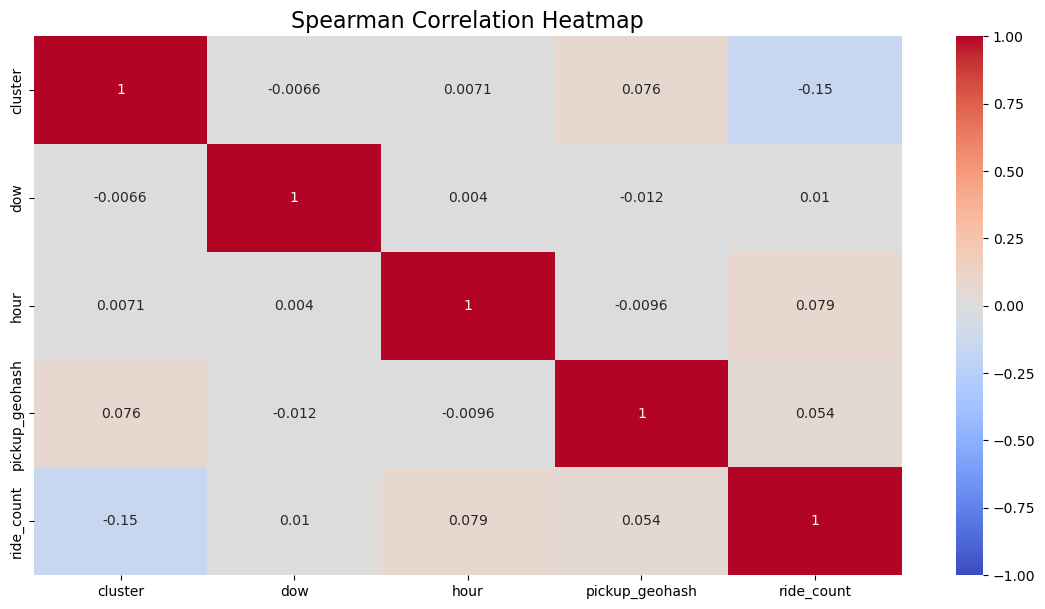

In [257]:
plt.figure(figsize=(14,7))
sns.heatmap(final_data.corr('spearman'), annot=True, vmin=-1, vmax=1, cmap='coolwarm')

plt.title('Spearman Correlation Heatmap', fontsize=16)
plt.show()

In [309]:
# Splitting the dataset for training:

X = final_data.drop(columns=['ride_count'])  # All columns except target
y = final_data['ride_count']  # Target variable

# Splitting the dataset into training and test set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=30)

In [271]:
# Helper function to evaluate model performance with cross-validation
def cross_val_evaluate(model, X, y, cv=5):
    start_time = time.time()
    
    scoring = {
        'MAE': 'neg_mean_absolute_error',
        'R2': 'r2'
    }
    
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True)
    training_time = time.time() - start_time
    
    metrics = {
        'MAE': -scores['test_MAE'].mean(),
        'R2': scores['test_R2'].mean(),
        'Training Time': training_time
    }
    
    return metrics

In [292]:
# Define the models
models = {
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'LightGBM': LGBMRegressor()
}

results = {}
best_models = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    # Create a pipeline for the current model
    metrics = cross_val_evaluate(model, X_train, y_train)
    results[model_name] = metrics
    
# Display the results
results_df = pd.DataFrame(results).T
print(results_df)

Training RandomForest...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 1995, number of used features: 4
[LightGBM] [Info] Start training from score 21.833083
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 1995, number of used features: 4
[LightGBM] [Info] Start training from score 20.719799
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 1995

__Reasons for choosing the models__:

- __Random Forest Regressor__: Random Forest is an ensemble learning method that constructs a multitude of decision trees during training and outputs the mean prediction of the individual trees for regression tasks. It helps reduce overfitting and improves accuracy.

- __XGBoost Regressor__: XGBoost is an optimized gradient boosting algorithm that is widely used for regression tasks. It sequentially builds a series of decision trees, correcting errors of the previous ones, and combines their predictions. This suffers the problems of overfitting as this tries to fix the previous errors that tends to capture some unwanted patterns.

- __LightGBM__ is another gradient boosting framework that is often faster and more memory efficient than XGBoost. It achieves this by using a histogram-based algorithm for splitting nodes, which reduces the computational cost compared to XGBoost's exact algorithm.

__Insight from the above training using cross validation__:

While `XGBoost` and `LightGBM` produced similar results in terms of mean absolute error `(MAE)` and `R-squared (R²)`, `XGBoost` ultimately outperformed `LightGBM` in this specific case.

__Hyperparameter Tuning__

In [310]:
# Define parameter grids for hyperparameter tuning
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, 30]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
#         'model__max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.3]
    },
    'LightGBM': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.3]
    }
}

# Train and tune each model using GridSearchCV
best_models = {}
for model_name, model in models.items():
    # Create a GridSearchCV object
    grid_search = GridSearchCV(model, param_grids[model_name], cv=3, scoring='r2', n_jobs=-1)
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Store the best model and parameters
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best {model_name} model: {grid_search.best_params_} with the best score {grid_search.best_score_}")

Best RandomForest model: {'max_depth': 20, 'n_estimators': 100} with the best score 0.9754822336597097
Best XGBoost model: {'learning_rate': 0.1, 'n_estimators': 200} with the best score 0.9738622388809378
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 2494, number of used features: 4
[LightGBM] [Info] Start training from score 21.315156
Best LightGBM model: {'learning_rate': 0.3, 'n_estimators': 200} with the best score 0.9726080331669507


In [314]:
# Helper function to evaluate model performance on the test set
def test_set_evaluate(model, X_test, y_test):
    start_time = time.time()
    
    y_pred = model.predict(X_test)
    evaluation_time = time.time() - start_time
    
    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'Evaluation Time': evaluation_time
    }
    
    return metrics

# Evaluate the final models on the test set
test_results = {}
for model_name, model in best_models.items():
    metrics = test_set_evaluate(model, X_test, y_test)
    test_results[model_name] = metrics

# Display the test results
test_results_df = pd.DataFrame(test_results).T
print(test_results_df)

                   MAE        R2  Evaluation Time
RandomForest  3.586317  0.983736         0.037382
XGBoost       3.697968  0.984664         0.007595
LightGBM      4.235638  0.981247         0.015055


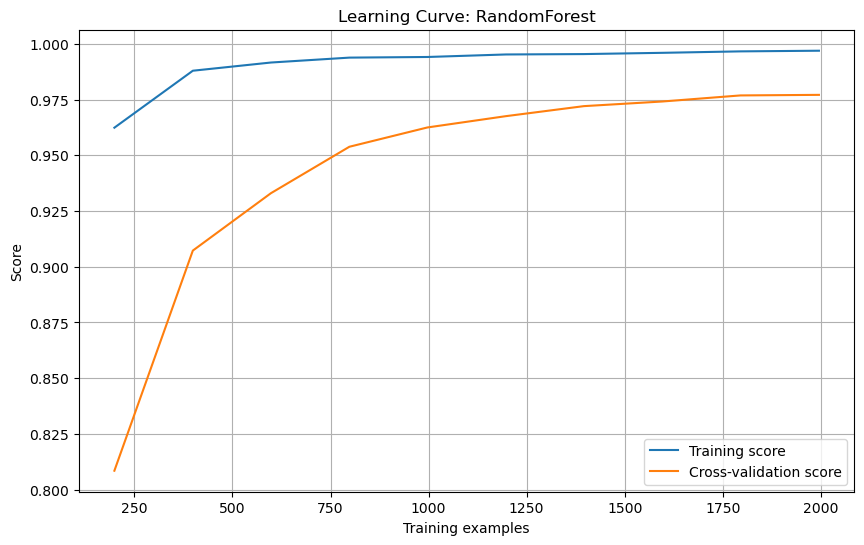

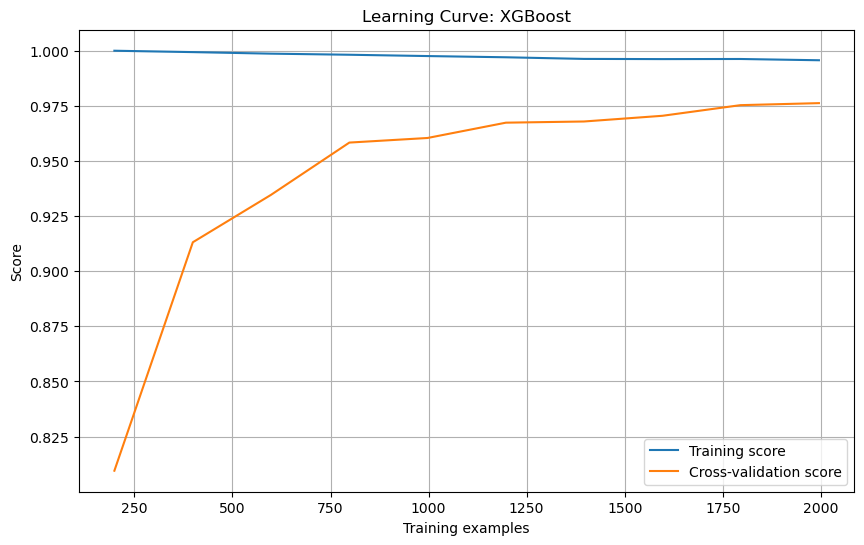

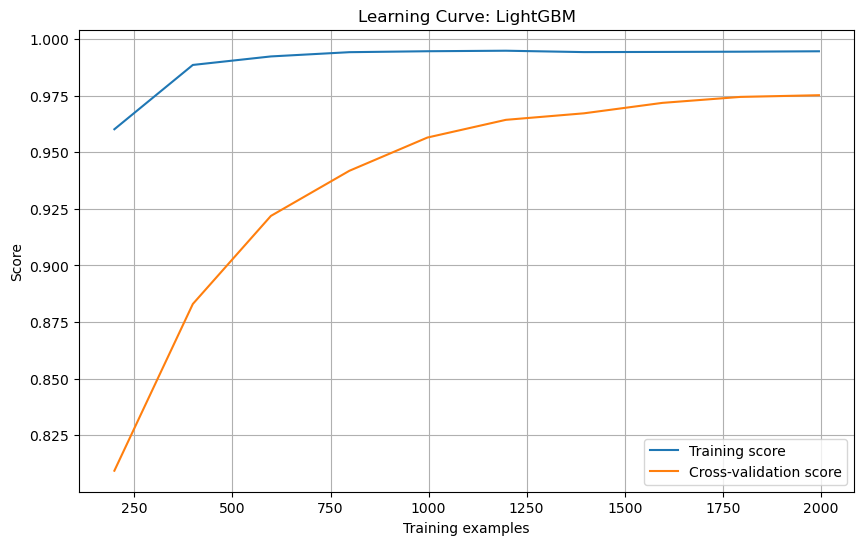

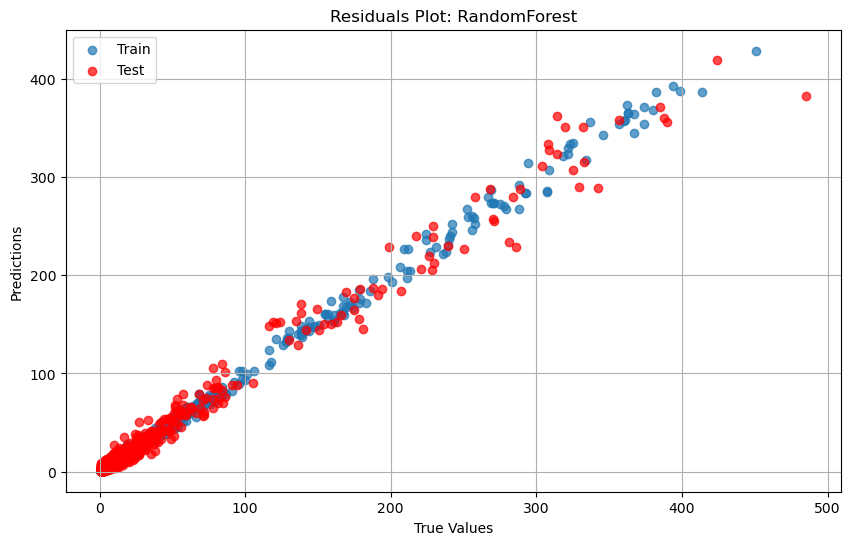

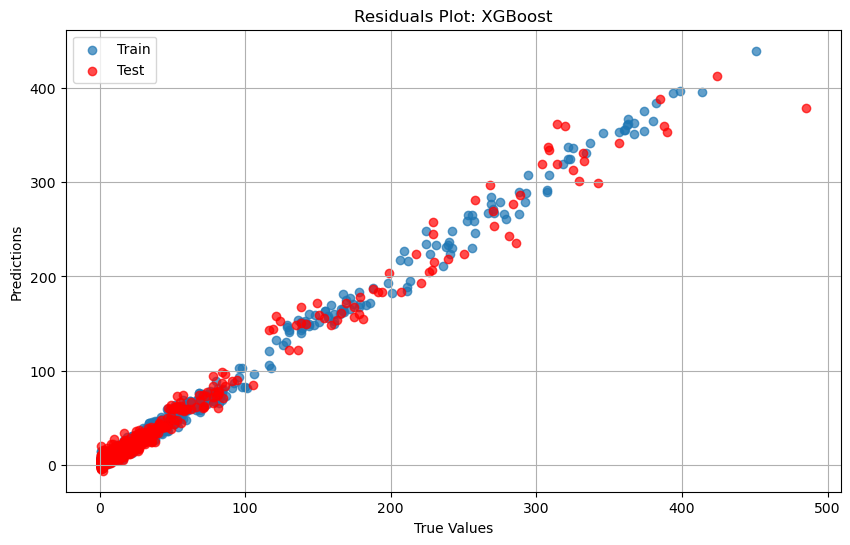

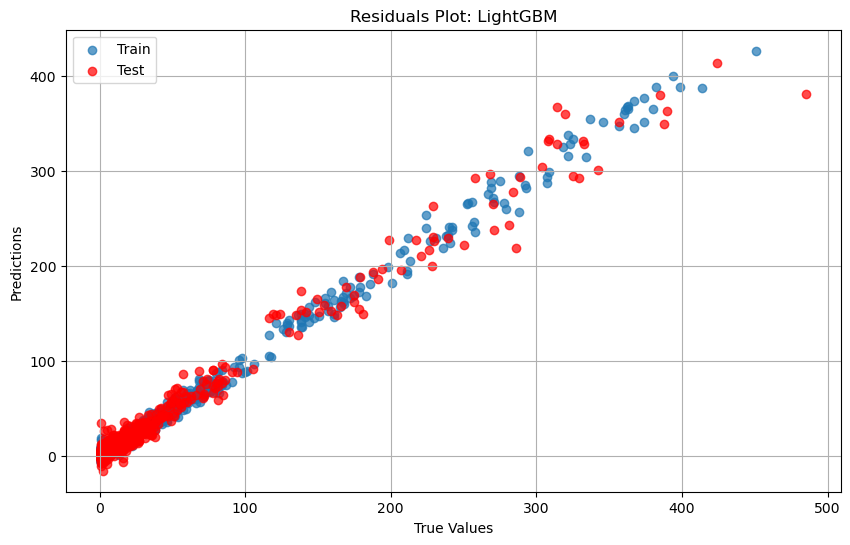

In [315]:
# Function to plot learning curves
def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, n_jobs=-1, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
    plt.title(f'Learning Curve: {title}')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    plt.show()

# Plot learning curves for the tuned models
for model_name, model in best_models.items():
    plot_learning_curve(model, X_train, y_train, model_name)

# Function to plot residuals
def plot_residuals(model, X_train, y_train, X_test, y_test, title):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_train, y_train_pred, label='Train', alpha=0.7)
    plt.scatter(y_test, y_test_pred, label='Test', alpha=0.7, color='red')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f'Residuals Plot: {title}')
    plt.legend()
    plt.grid()
    plt.show()

# Plot residuals for the tuned models
for model_name, model in best_models.items():
    plot_residuals(model, X_train, y_train, X_test, y_test, model_name)


### Final Insights  results:

- __Residual Plots__: Residual plots display the differences between observed and predicted values (residuals). They help assess the quality of a regression model. Any discernible patterns suggest potential issues, such as non-linearity or model misspecification. In layman's terms, from the above plots for both the regressors, the model has performed pretty well as train and test data points are overlapping.


- __Learning Curves__: Learning curves plot the training and validation scores against the number of training examples. They provide insights into how a model learns over time. A small gap between training and validation scores suggests that the model generalizes well to unseen data. From the plots, it can be understood that as the number of samples increase, the gap between the curves shows a reducing trend which means that more data can improve the model even better.

## Chapter 7: Guiding Drivers with Machine Learning Predictions

In [332]:
driver_current_info = {
    'cluster': [10],            # Driver's current cluster
    'dow': [current_dow],       # Day of the week 
    'hour': [current_hour],     # Hour of the day
    'pickup_geohash': [26],    # Ordinal encoded geohash for current location
}

# Convert the input data into a DataFrame for prediction
driver_current_df = pd.DataFrame(driver_current_info)

# Use the trained model to predict the expected ride counts in nearby clusters
predicted_ride_counts = best_models['XGBoost'].predict(driver_current_df)

# guide the driver to the nearest cluster with the highest predicted ride count
recommended_cluster_idx = np.argmax(predicted_ride_counts)

print(f"The driver's current cluster is {driver_current_info['cluster'][0]}.")
print(f"At {driver_current_info['hour'][0]}:00, the recommended cluster to move to is {recommended_cluster_idx} based on predicted ride count.")

The driver's current cluster is 10.
At 17:00, the recommended cluster to move to is 0 based on predicted ride count.


## Chapter 8: Communicating Model Recommendations to Drivers

The model recommendations should be communicated to drivers in a clear, actionable, and timely manner. Below are the some of the steps and considerations I feel are valid for communicating the recommendations effectively:

1. __Real-Time Notifications via Driver App__:
- __Push Notifications__: Drivers should receive push notifications that guide them toward high-demand areas. Notifications should include:
    - __Current Cluster Information__: Letting drivers know if they are currently in a high-demand area.
    - __Recommended Cluster Information__: Suggesting nearby areas that are predicted to have higher demand and potential for higher earnings.
    - __Time-Sensitive Information__: Since demand predictions are time-sensitive (e.g., based on hour of the day and day of the week), these notifications should be updated frequently to reflect real-time data.
    - __Example Message__:
"High demand alert! Cluster 12 has 20% more ride requests compared to your current location. Move to this area for more ride opportunities!"

    
2. __In-App Demand Heat Maps__:
- __Visual Demand Representation__: Drivers could view demand heat maps in the app, color-coded to reflect the demand intensity (e.g., green for low demand, red for high demand). This allows drivers to visually explore different areas and make more informed decisions based on predictions.

- __Geospatial Clustering__: Highlight areas on the map where multiple clusters are grouped, giving drivers an easy understanding of which regions have high demand. Include pop-up notifications when clicking on specific regions, showing predicted ride count and potential earnings.


3. __Avoiding Overcrowding__:
- __Staggered Recommendations__: To avoid overconcentration of drivers in one location, recommendations should account for the number of drivers already on their way to a high-demand region. Use the model to distribute drivers effectively across different regions to maintain balance in supply and demand.


## Chapter 9: Experiment Design for Live Operations

After some research about this problem of efficient supply allocation of raid hailing platforms, I came across some ideas as to how to experiment to validate the solution in live operations. 

The __goal__ of the experiment is to validate whether the machine learning-based recommendations improve driver earnings, reduce rider waiting time, and enhance overall supply-demand balance on the platform.

__Marketplace-Specific Considerations__:
- __Geospatial Dynamics__: The ride-hailing marketplace is location-sensitive. Demand varies significantly across regions, and drivers can only service nearby areas. Thus, recommendations should not focus on distant clusters.
- __Driver Autonomy__: Drivers may not always follow recommendations, so flexibility should be considered when analyzing results.
- __Dynamic Demand__: Demand can fluctuate rapidly (e.g., due to weather or events). The model must handle real-time changes.

__Experimental Design (A/B Testing)__:

1. __Control Group vs. Treatment Group__:
    - __Control Group(A)__: Drivers in this group receive no machine learning-based recommendations. They rely solely on their own experience or current platform guidance for navigating to high-demand areas.
    - __Treatment Group(B)__: Drivers in this group receive real-time, machine learning-based recommendations via the app, with predictions on demand and potential earnings.
    

2. __Randomized Assignment__:
    - Randomly assign drivers to the control and treatment groups, ensuring a representative sample in terms of geography, experience level, and performance metrics.
    

3. __Key Performance Indicators (KPIs)__:
    - __Driver Earnings__: Measure the difference in average earnings per hour between the control and treatment groups. Higher earnings in the treatment group would indicate success.
    - __Ride fulfilment rate__: Track the percentage of ride requests successfully fulfilled in each group. An increase in fulfilled rides in the treatment group would show that supply allocation improved.
    - __Rider waiting time__: Compare the average rider waiting time between the two groups. A lower waiting time in the treatment group would suggest better matching of supply and demand.
    - __Driver acceptance of reccomendations__: Measure the percentage of times drivers in the treatment group follow the recommendations versus declining them. High acceptance would indicate trust in the system.
    
    
4. __Experiment Duration__:
    - The experiment should run for a sufficient period to capture both peak and non-peak hours, as well as weekend vs. weekday demand patterns. A minimum of 2–4 weeks is recommended to gather statistically significant data.
    
    
5. __Hypothesis Testing__:
    - __Null Hypothesis (H₀)__: There is no significant difference in driver earnings and ride fulfillment rate between the control and treatment groups.
    - __Alternative Hypothesis (H₁)__: The treatment group has significantly higher driver earnings and a better ride fulfillment rate than the control group.
    
    
    
    
__Potential Challenges and Solutions__:
- __Overloading High-Demand Areas__: Drivers may overcrowd high-demand regions, causing local supply to exceed demand. To mitigate this, implement a dynamic feedback mechanism that adjusts recommendations based on real-time driver locations.
- __Unexpected Events__: Factors like road closures or sudden weather changes can distort predictions. To handle this, build in real-time adjustments to the model that allow it to react to these unforeseen events.
- __Driver Trust__: Drivers may be skeptical of following algorithmic recommendations. To address this, start with a smaller, trusted group of drivers in a pilot phase to gather feedback and make the system more intuitive.